# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.


### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на отмасштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Я буду использовать датасет Wine Reviews - датасет для распознавания вин

In [5]:
data = pd.read_csv('./data/winemag-data-130k-v2.csv', sep=",")

In [6]:
# размер набора данных
data.shape

(129971, 14)

In [7]:
# типы колонок
data.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [8]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [9]:
# Первые 5 строк датасета
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [10]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 129971


# 1. Обработка пропусков в данных

## 1.1. Простые стратегии - удаление или заполнение нулями

In [11]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)
#в результате важнейшие фичи, такие как тип винограда, цена и регион, удалены

((129971, 14), (129971, 5))

In [12]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)
#сталов 6 раз меньше данных

((129971, 14), (22387, 14))

In [13]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [14]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,0,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,0,0,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",0,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,0,Alexander Peartree,0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## 1.2. "Внедрение значений" - импьютация (imputation)

### 1.2.1. Обработка пропусков в числовых данных

In [15]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка price. Тип данных float64. Количество пустых значений 8996, 6.92%.


In [16]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,price
0,NaN
1,15.0
2,14.0
3,13.0
4,65.0
5,15.0
6,16.0
7,24.0
8,12.0
9,27.0


In [17]:
# Фильтр по пустым значениям поля price 
data[data['price'].isnull()]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
13,13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte
30,30,France,Red cherry fruit comes laced with light tannin...,Nouveau,86,NaN,Beaujolais,Beaujolais-Villages,NaN,Roger Voss,@vossroger,Domaine de la Madone 2012 Nouveau (Beaujolais...,Gamay,Domaine de la Madone
31,31,Italy,Merlot and Nero d'Avola form the base for this...,Calanìca Nero d'Avola-Merlot,86,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Duca di Salaparuta 2010 Calanìca Nero d'Avola-...,Red Blend,Duca di Salaparuta
32,32,Italy,"Part of the extended Calanìca series, this Gri...",Calanìca Grillo-Viognier,86,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Duca di Salaparuta 2011 Calanìca Grillo-Viogni...,White Blend,Duca di Salaparuta
50,50,Italy,This blend of Nero d'Avola and Syrah opens wit...,Scialo,86,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Viticultori Associati Canicatti 2008 Scialo Re...,Red Blend,Viticultori Associati Canicatti
54,54,Italy,"A blend of Nero d'Avola and Nerello Mascalese,...",Rosso,85,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Corvo 2010 Rosso Red (Sicilia),Red Blend,Corvo
79,79,Portugal,"Grown on the sandy soil of Tejo, the wine is t...",Bridão,86,NaN,Tejo,NaN,NaN,Roger Voss,@vossroger,Adega Cooperativa do Cartaxo 2014 Bridão Touri...,Touriga Nacional,Adega Cooperativa do Cartaxo
137,137,South Africa,"This is great Chenin Blanc, wood fermented but...",Hope Marguerite,90,NaN,Walker Bay,NaN,NaN,Roger Voss,@vossroger,Beaumont 2005 Hope Marguerite Chenin Blanc (Wa...,Chenin Blanc,Beaumont
159,159,Italy,"Intense aromas of ripe red berry, menthol, esp...",Filo di Seta,91,NaN,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,Castello Romitorio 2011 Filo di Seta (Brunell...,Sangiovese,Castello Romitorio


In [18]:
# Запоминаем индексы строк с пустыми значениями
flt_index = data[data['price'].isnull()].index
flt_index

Int64Index([     0,     13,     30,     31,     32,     50,     54,     79,
               137,    159,
            ...
            129764, 129787, 129794, 129807, 129813, 129844, 129860, 129863,
            129893, 129964],
           dtype='int64', length=8996)

In [19]:
# Проверяем что выводятся нужные строки
data[data.index.isin(flt_index)]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
13,13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte
30,30,France,Red cherry fruit comes laced with light tannin...,Nouveau,86,NaN,Beaujolais,Beaujolais-Villages,NaN,Roger Voss,@vossroger,Domaine de la Madone 2012 Nouveau (Beaujolais...,Gamay,Domaine de la Madone
31,31,Italy,Merlot and Nero d'Avola form the base for this...,Calanìca Nero d'Avola-Merlot,86,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Duca di Salaparuta 2010 Calanìca Nero d'Avola-...,Red Blend,Duca di Salaparuta
32,32,Italy,"Part of the extended Calanìca series, this Gri...",Calanìca Grillo-Viognier,86,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Duca di Salaparuta 2011 Calanìca Grillo-Viogni...,White Blend,Duca di Salaparuta
50,50,Italy,This blend of Nero d'Avola and Syrah opens wit...,Scialo,86,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Viticultori Associati Canicatti 2008 Scialo Re...,Red Blend,Viticultori Associati Canicatti
54,54,Italy,"A blend of Nero d'Avola and Nerello Mascalese,...",Rosso,85,NaN,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Corvo 2010 Rosso Red (Sicilia),Red Blend,Corvo
79,79,Portugal,"Grown on the sandy soil of Tejo, the wine is t...",Bridão,86,NaN,Tejo,NaN,NaN,Roger Voss,@vossroger,Adega Cooperativa do Cartaxo 2014 Bridão Touri...,Touriga Nacional,Adega Cooperativa do Cartaxo
137,137,South Africa,"This is great Chenin Blanc, wood fermented but...",Hope Marguerite,90,NaN,Walker Bay,NaN,NaN,Roger Voss,@vossroger,Beaumont 2005 Hope Marguerite Chenin Blanc (Wa...,Chenin Blanc,Beaumont
159,159,Italy,"Intense aromas of ripe red berry, menthol, esp...",Filo di Seta,91,NaN,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,Castello Romitorio 2011 Filo di Seta (Brunell...,Sangiovese,Castello Romitorio


In [20]:
# фильтр по колонке
data_num[data_num.index.isin(flt_index)]['price'].head()

0    NaN
13   NaN
30   NaN
31   NaN
32   NaN
Name: price, dtype: float64

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html#impute

In [21]:
data_num_price = data_num[['price']]
data_num_price.head()

,price
0,NaN
1,15.0
2,14.0
3,13.0
4,65.0


In [22]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [23]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_price)
mask_missing_values_only

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [24]:
strategies=['mean', 'median','most_frequent']

In [25]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_price)
    return data_num_imp[mask_missing_values_only]

In [26]:
strategies[0], test_num_impute(strategies[0])

('mean', array([35.36338913, 35.36338913, 35.36338913, ..., 35.36338913,
        35.36338913, 35.36338913]))

In [27]:
strategies[1], test_num_impute(strategies[1])

('median', array([25., 25., 25., ..., 25., 25., 25.]))

In [28]:
strategies[2], test_num_impute(strategies[2])

('most_frequent', array([20., 20., 20., ..., 20., 20., 20.]))

In [29]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [30]:
data[['price']].describe()

,price
count,120975.000000
mean,35.363389
std,41.022218
min,4.000000
25%,17.000000
50%,25.000000
75%,42.000000
max,3300.000000


In [31]:
test_num_impute_col(data, 'price', strategies[0])

('price', 'mean', 8996, 35.363389129985535, 35.363389129985535)

In [32]:
test_num_impute_col(data, 'price', strategies[1])

('price', 'median', 8996, 25.0, 25.0)

In [33]:
test_num_impute_col(data, 'price', strategies[2])

('price', 'most_frequent', 8996, 20.0, 20.0)

### 1.2.2. Обработка пропусков в категориальных данных

In [34]:
data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [35]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка country. Тип данных object. Количество пустых значений 63, 0.05%.
Колонка designation. Тип данных object. Количество пустых значений 37465, 28.83%.
Колонка province. Тип данных object. Количество пустых значений 63, 0.05%.
Колонка region_1. Тип данных object. Количество пустых значений 21247, 16.35%.
Колонка region_2. Тип данных object. Количество пустых значений 79460, 61.14%.
Колонка taster_name. Тип данных object. Количество пустых значений 26244, 20.19%.
Колонка taster_twitter_handle. Тип данных object. Количество пустых значений 31213, 24.02%.
Колонка variety. Тип данных object. Количество пустых значений 1, 0.0%.


1. region2  - это уточнение region1, в нем содержиться более 60% пропусков, поэтому его можно убрать 
2. designayion имеет около трети пропусков
3. taster_twitter_handle - это уточнение taster_name

Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [36]:
cat_temp_data = data[['region_1']]
cat_temp_data.head()

,region_1
0,Etna
1,NaN
2,Willamette Valley
3,Lake Michigan Shore
4,Willamette Valley


In [37]:
cat_temp_data['region_1'].unique()

array(['Etna', nan, 'Willamette Valley', ..., 'Del Veneto',
       'Bardolino Superiore', 'Paestum'], dtype=object)

In [38]:
cat_temp_data[cat_temp_data['region_1'].isnull()].shape

(21247, 1)

In [39]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['Etna'],
       ['Napa Valley'],
       ['Willamette Valley'],
       ...,
       ['Alsace'],
       ['Alsace'],
       ['Alsace']], dtype=object)

In [40]:
#самое частое значение
u, indices = np.unique(data_imp2, return_inverse=True)
print(u[np.argmax(np.bincount(indices))])

Napa Valley


In [41]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['Abruzzo', 'Adelaida District', 'Adelaide', ...,
       'Yorkville Highlands', 'Yountville', 'Zonda Valley'], dtype=object)

In [42]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='!!!')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['Etna'],
       ['!!!'],
       ['Willamette Valley'],
       ...,
       ['Alsace'],
       ['Alsace'],
       ['Alsace']], dtype=object)

In [43]:
np.unique(data_imp3)

array(['!!!', 'Abruzzo', 'Adelaida District', ..., 'Yorkville Highlands',
       'Yountville', 'Zonda Valley'], dtype=object)

In [44]:
data_imp3[data_imp3=='!!!'].size

21247

# 2. Преобразование категориальных признаков в числовые

In [45]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,Etna
1,Napa Valley
2,Willamette Valley
3,Lake Michigan Shore
4,Willamette Valley
5,Navarra
6,Vittoria
7,Alsace
8,Napa Valley
9,Alsace


## 2.1. Кодирование категорий целочисленными значениями - [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [46]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [47]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [48]:
cat_enc['c1'].unique()

array(['Etna', 'Napa Valley', 'Willamette Valley', ..., 'Del Veneto',
       'Bardolino Superiore', 'Paestum'], dtype=object)

In [49]:
np.unique(cat_enc_le)

array([   0,    1,    2, ..., 1226, 1227, 1228])

In [50]:
le.inverse_transform([0, 1, 2, 3])

array(['Abruzzo', 'Adelaida District', 'Adelaide', 'Adelaide Hills'],
      dtype=object)

## 2.2. Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [51]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [52]:
cat_enc.shape

(129971, 1)

In [53]:
cat_enc_ohe.shape

(129971, 1229)

In [54]:
cat_enc_ohe

<129971x1229 sparse matrix of type '<class 'numpy.float64'>'
	with 129971 stored elements in Compressed Sparse Row format>

In [55]:
cat_enc_ohe.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
cat_enc.head(10)

,c1
0,Etna
1,Napa Valley
2,Willamette Valley
3,Lake Michigan Shore
4,Willamette Valley
5,Navarra
6,Vittoria
7,Alsace
8,Napa Valley
9,Alsace


## 2.3. [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [57]:
pd.get_dummies(cat_enc).head()

,c1_Abruzzo,c1_Adelaida District,c1_Adelaide,c1_Adelaide Hills,c1_Adelaide Plains,c1_Aglianico d'Irpinia,c1_Aglianico del Beneventano,c1_Aglianico del Taburno,c1_Aglianico del Vulture,c1_Agrelo,...,c1_Yadkin Valley,c1_Yakima Valley,c1_Yamhill County,c1_Yarra Valley,c1_Yecla,c1_Yolo County,c1_York Mountain,c1_Yorkville Highlands,c1_Yountville,c1_Zonda Valley
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,region_1_Abruzzo,region_1_Adelaida District,region_1_Adelaide,region_1_Adelaide Hills,region_1_Adelaide Plains,region_1_Aglianico d'Irpinia,region_1_Aglianico del Beneventano,region_1_Aglianico del Taburno,region_1_Aglianico del Vulture,region_1_Agrelo,...,region_1_Yakima Valley,region_1_Yamhill County,region_1_Yarra Valley,region_1_Yecla,region_1_Yolo County,region_1_York Mountain,region_1_Yorkville Highlands,region_1_Yountville,region_1_Zonda Valley,region_1_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины.

In [59]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## 3.1. [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [60]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values="NaN", strategy="mean", axis=0)
q = imp.fit_transform(data[['price']])
data['price'] = q

C:\Users\pisar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [61]:
data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.000000,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.000000,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.000000,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.000000,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.000000,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [62]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['price']])

count    129971.000000
mean         35.363389
std          39.577066
min           4.000000
25%          18.000000
50%          28.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64


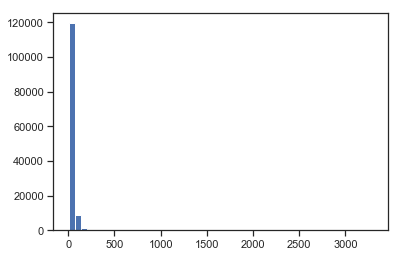

In [63]:
plt.hist(data['price'], 50)
print(data['price'].describe())
plt.show()

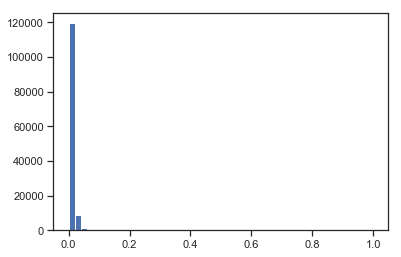

In [64]:
plt.hist(sc1_data, 50)
plt.show()

## 3.2. Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [65]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['price']])

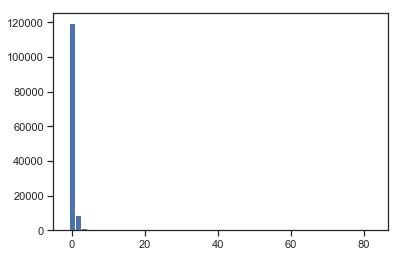

In [66]:
plt.hist(sc2_data, 50)
plt.show()

## 3.3. [Нормализация данных](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)

In [67]:
sc3 = Normalizer()
sc3_data = sc3.fit_transform(data[['price']])

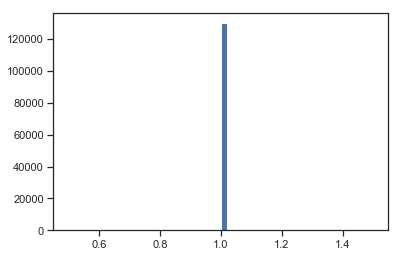

In [68]:
plt.hist(sc3_data, 50)
plt.show()

# Дополнительные источники
- [Руководство scikit-learn по предобработке данных](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Kaggle Data Cleaning Challenge: Handling missing values (упражнения с пояснениями по обработке пропущенных значений и масштабированию признаков)](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)

- [Краткое руководство по категориальным признакам](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)
